# Romulo plot

> Romulo plots are heatmaps designed to give a quick overview of CML (commercial microwave link) variables across time and sublinks — useful to spot attenuation bursts, sensor issues or systematic patterns - and to compare them with gauge data.

In [ ]:
#| default_exp plot._romulo

## Romulo for CML

In [ ]:
#| export
import xarray as xr
import matplotlib.pyplot as plt
from raincell import open_cml_sample, open_gauge_sample

In [ ]:
sel_time = {"time": slice("2019-07-17", "2019-07-27")}
cml = open_cml_sample().sel(**sel_time)
att = cml["tsl_avg"] - cml["rsl_avg"]
att

<xarray.DataArray (cml_id: 126, sublink_id: 6, time: 1052)> Size: 6MB
57.5 57.6 57.6 57.6 57.6 57.7 57.7 57.7 57.7 ... nan nan nan nan nan nan nan nan
Coordinates: (10)

In [ ]:
#| hide
att_stacked = att.stack(sublink=('cml_id', 'sublink_id'))
att_stacked

<xarray.DataArray (time: 1052, sublink: 756)> Size: 6MB
57.5 56.6 nan nan nan nan 60.6 61.2 nan ... nan nan 47.9 47.9 nan nan nan nan
Coordinates: (11)

In [ ]:
#| hide
new_index = [f"{cml}__{sub}" for cml, sub in att_stacked.sublink.values]
att_reindexed = att_stacked.drop_vars(['cml_id', 'sublink_id', 'sublink']).assign_coords(sublink=new_index)
att_reindexed

<xarray.DataArray (time: 1052, sublink: 756)> Size: 6MB
57.5 56.6 nan nan nan nan 60.6 61.2 nan ... nan nan 47.9 47.9 nan nan nan nan
Coordinates: (9)

In [ ]:
#| hide
att_reindexed = att_reindexed.rename({"sublink": "sublink_id"})
att_reindexed

<xarray.DataArray (time: 1052, sublink_id: 756)> Size: 6MB
57.5 56.6 nan nan nan nan 60.6 61.2 nan ... nan nan 47.9 47.9 nan nan nan nan
Coordinates: (9)

In [ ]:
#| hide
att_cleaned = att_reindexed.dropna(dim='sublink_id', how='all')
att_cleaned

<xarray.DataArray (time: 1052, sublink_id: 251)> Size: 2MB
57.5 56.6 60.6 61.2 46.6 45.7 42.5 44.2 ... 70.5 51.4 50.7 54.7 54.6 47.9 47.9
Coordinates: (9)

In [ ]:
#| exporti
def reduce_cml_id_dim(
    cml: xr.DataArray | xr.Dataset, # CML in OpenSense standard
    drop_allna: bool = True # Drop sublinks with all nan values in time
    ) -> xr.DataArray | xr.Dataset:
    """Reduce one CML data dimension by combining cml_id and sublink_id dims into a single `sublink_id` dimension."""
    stacked = cml.stack(sublink=('cml_id', 'sublink_id'))
    new_index = [f"{cml}__{sub}" for cml, sub in stacked.sublink.values]
    reindexed = stacked.drop_vars(['cml_id', 'sublink_id', 'sublink']).assign_coords(sublink=new_index)
    reindexed = reindexed.rename({"sublink": "sublink_id"})
    return  reindexed.dropna(dim='sublink_id', how='all') if drop_allna else reindexed

The OpenSense standard defines three dimensions. However, Romulo plots are two-dimensional. For this reason, we need to reduce the data from three dimensions to two. This can be done by combining the `cml_id` and `sublink_id` values to create a single dimension.

In [ ]:
#| hide
reduce_cml_id_dim(att)

<xarray.DataArray (time: 1052, sublink_id: 251)> Size: 2MB
57.5 56.6 60.6 61.2 46.6 45.7 42.5 44.2 ... 70.5 51.4 50.7 54.7 54.6 47.9 47.9
Coordinates: (9)

Data is sorted by length because, for equal frequency and polarization, $A_{rain} \propto length$.

In [ ]:
#| hide
att_sorted = att_cleaned.sortby("length")
att_sorted

<xarray.DataArray (time: 1052, sublink_id: 251)> Size: 2MB
63.9 42.4 43.6 43.3 45.3 45.7 33.6 59.4 ... 64.3 61.8 61.8 56.9 55.6 53.6 52.6
Coordinates: (9)

<matplotlib.collections.QuadMesh>

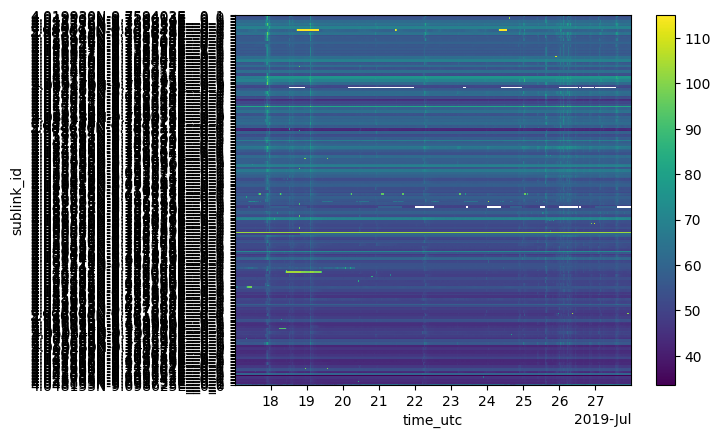

In [ ]:
#| hide
#| eval: false
att_sorted.plot(x="time")

<matplotlib.collections.QuadMesh>

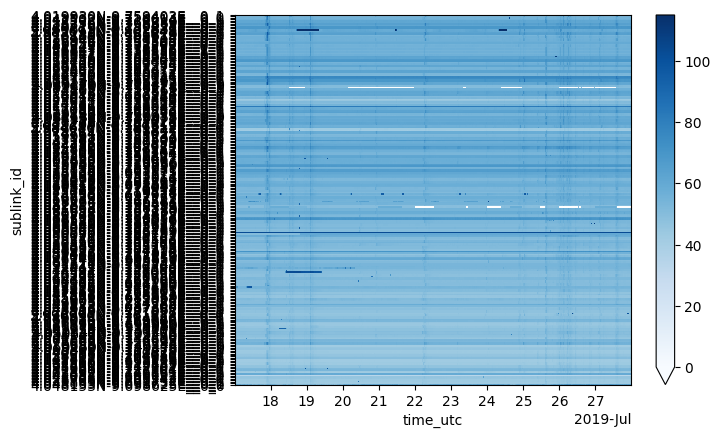

In [ ]:
#| hide
#| eval: false
att_sorted.plot(x="time", vmin=0, cmap='Blues', extend='min')

In [ ]:
#| hide
#| eval: false
cmap = plt.cm.Blues.copy()
cmap.set_under('red')

<matplotlib.collections.QuadMesh>

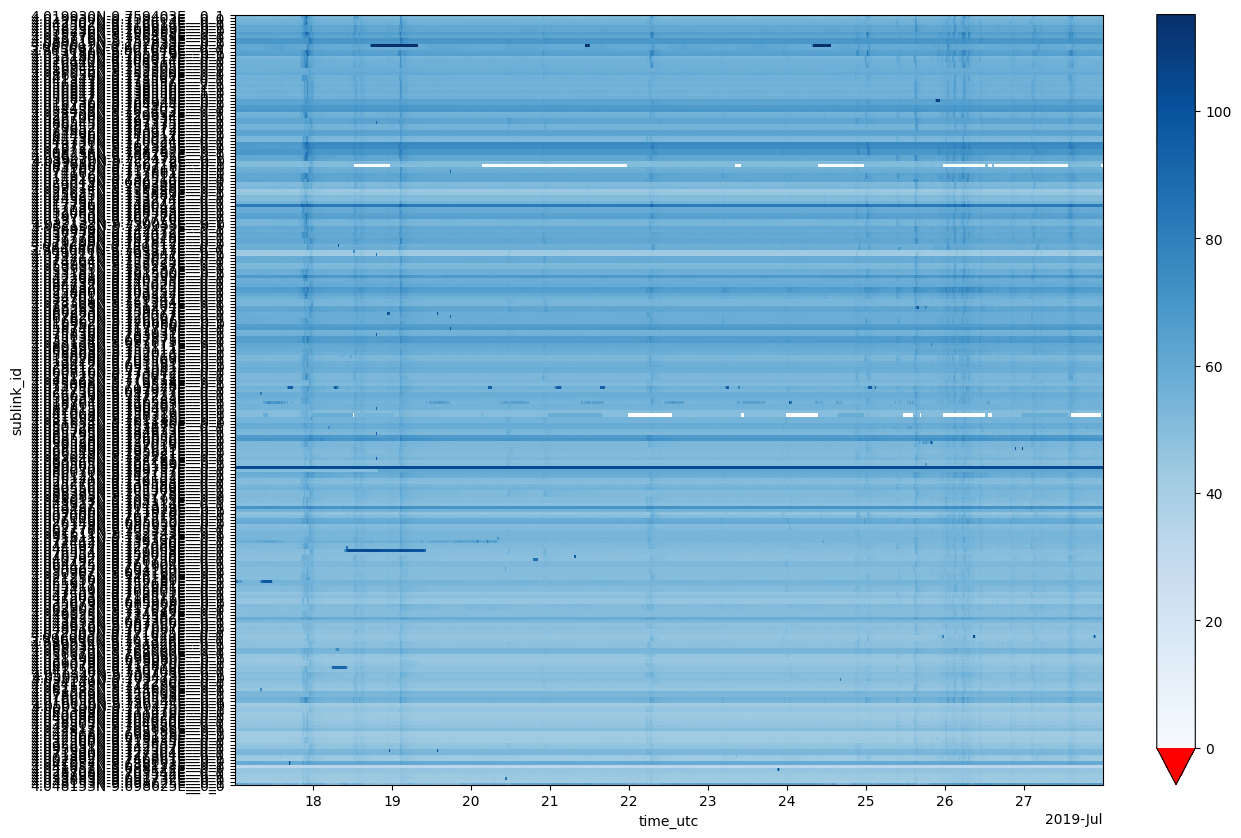

In [ ]:
#| hide
#| eval: false
fig, ax = plt.subplots(figsize=(14, 10))
att_sorted.plot(ax=ax, x="time", vmin=0, cmap=cmap, extend='min')

In [ ]:
#| hide
#| eval: false
from matplotlib.ticker import MaxNLocator

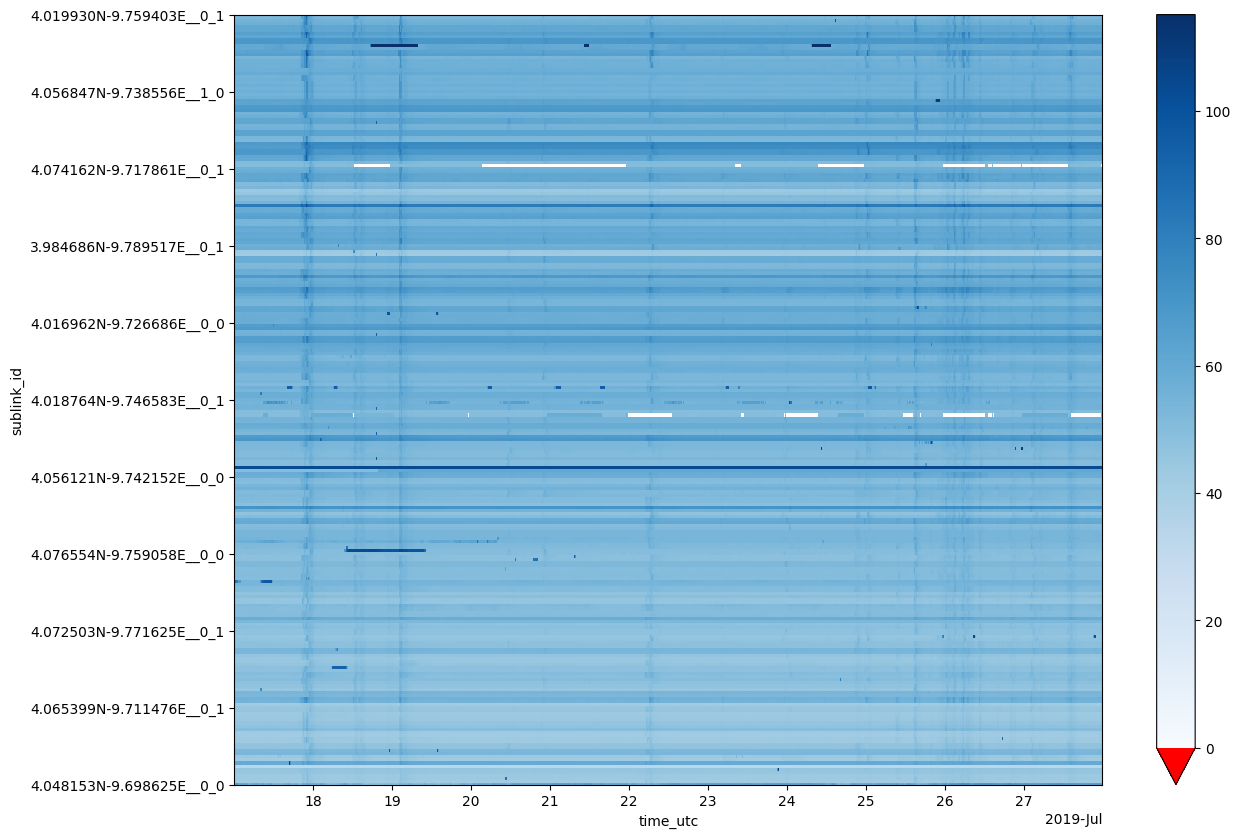

In [ ]:
#| hide
#| eval: false
ax.yaxis.set_major_locator(MaxNLocator(nbins=10))
fig

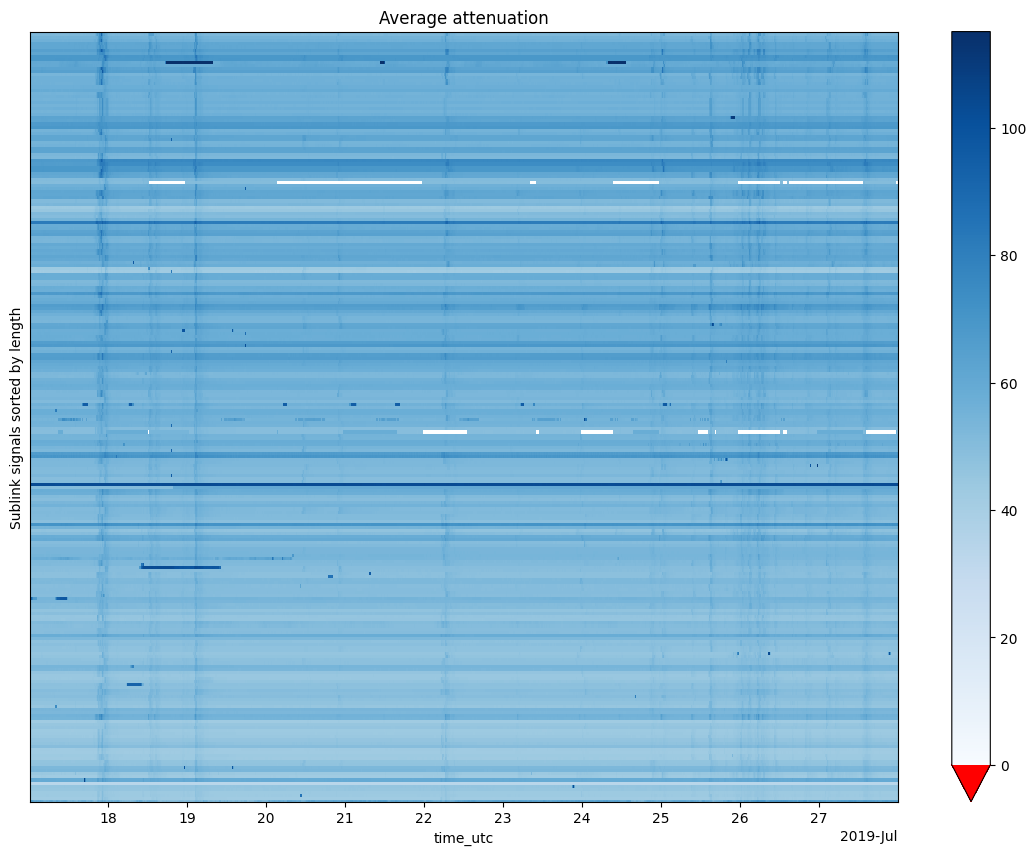

In [ ]:
#| hide
#| eval: false
ax.set_yticks([])
ax.set_ylabel("Sublink signals sorted by length")
ax.set_title("Average attenuation")
fig

In [ ]:
#| export
def romulo_plot_cml(
        cml: xr.DataArray, # CML data to plot
        title: str = None, # Title for the plot
        fig: plt.Figure = None, 
        ax: plt.Axes = None, 
        figsize: tuple = (16, 9), # Figure size, only used if fig or ax are None
        vmax: float | None = None # Maximum value for colormap
        ) -> tuple[plt.Figure, plt.Axes]:
    """Plot an overview of the CML data sorted by length. Negative values, which are not phisically possible are shown in red."""
    cml_sorted = reduce_cml_id_dim(cml).sortby("length")
    
    cmap = plt.cm.Blues.copy()
    cmap.set_under('red')
    
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    cml_sorted.plot(ax=ax, x="time", vmin=0, vmax=vmax,cmap=cmap, extend='min')
    
    ax.set_yticks([])
    ax.set_ylabel("Sublink data sorted by length")
    ax.set_title(title or cml.name)
    
    return fig, ax

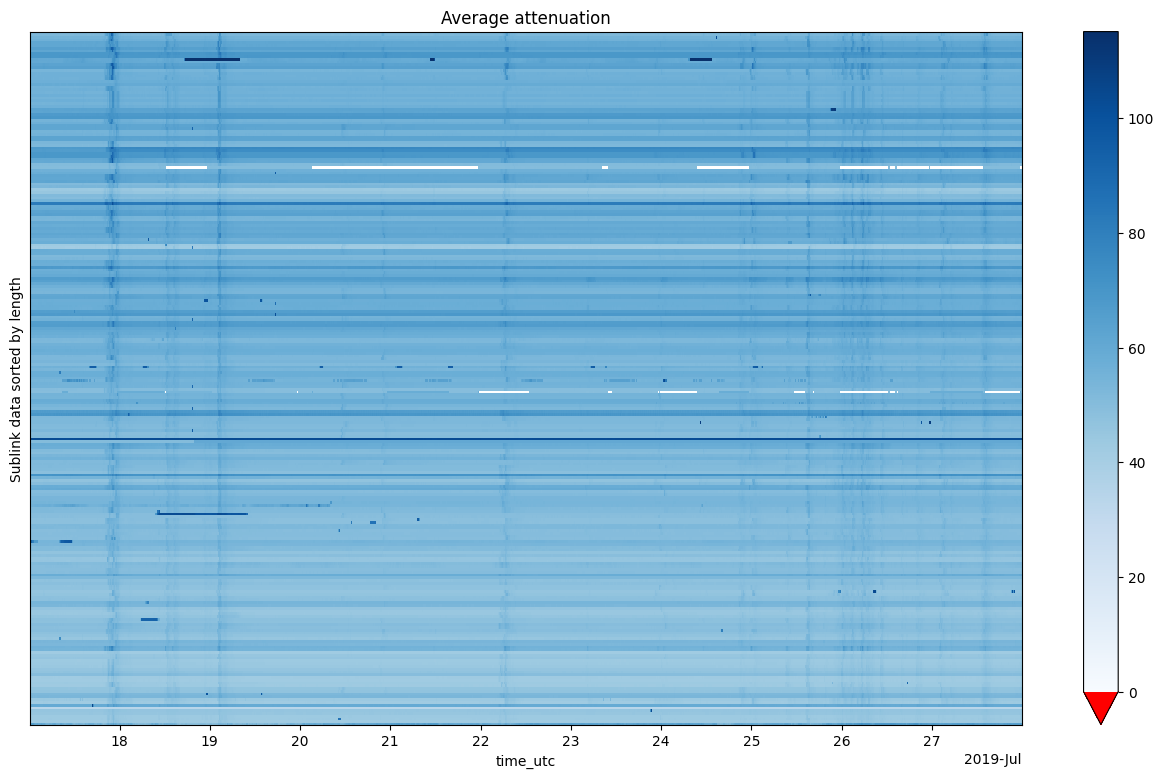

In [ ]:
romulo_plot_cml(att, "Average attenuation");

In order to plot negative data (for example RSL) you can do:

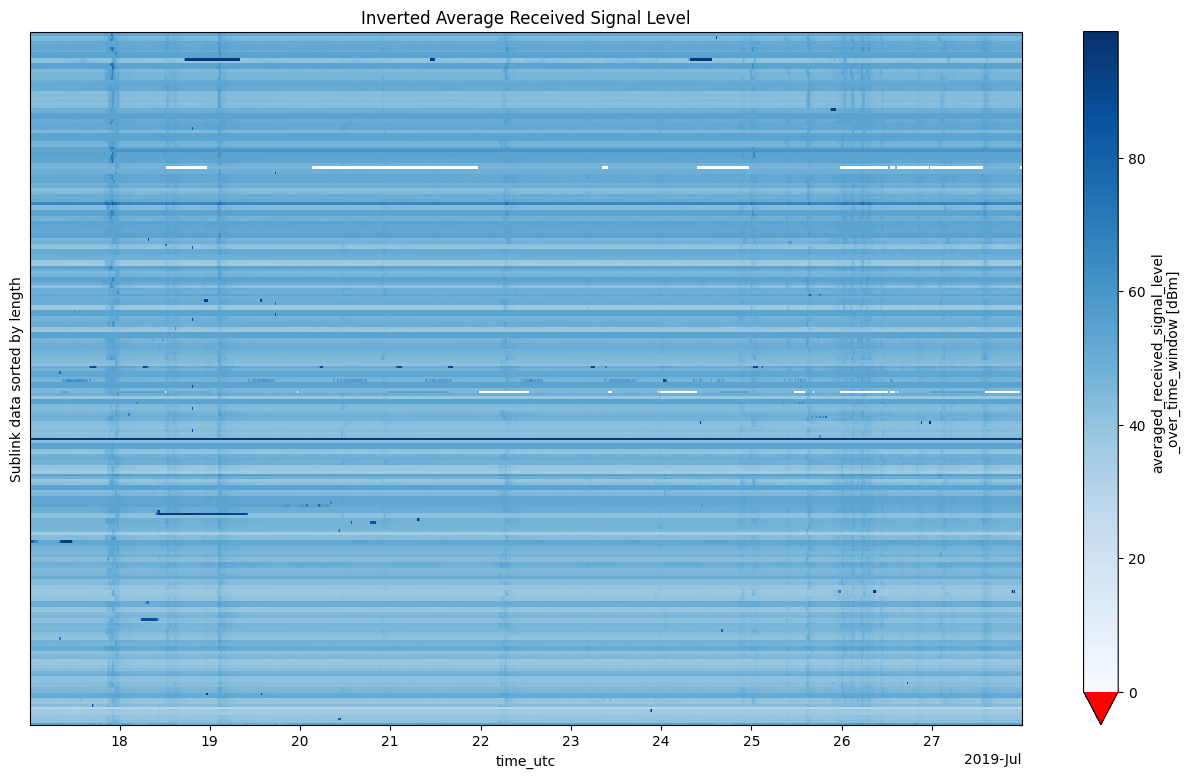

In [ ]:
romulo_plot_cml(-cml["rsl_avg"], "Inverted Average Received Signal Level");

## Romulo for gauges

In [ ]:
gauges = open_gauge_sample().sel(**sel_time)

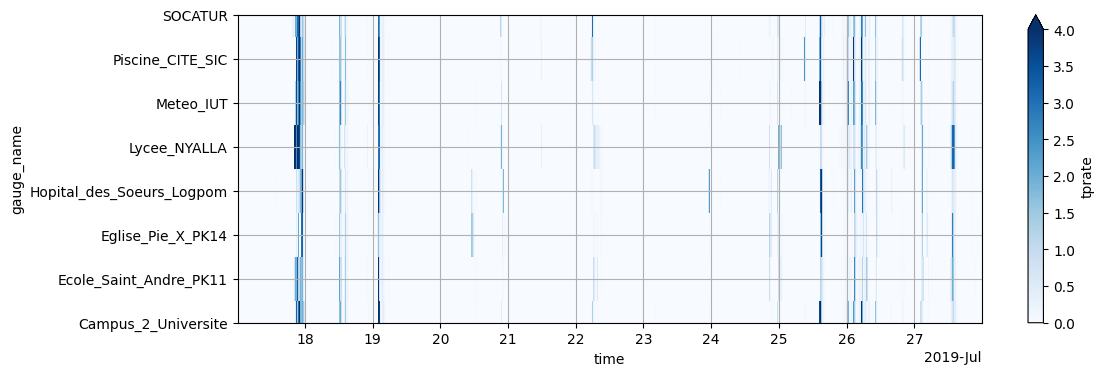

In [ ]:
#| hide
#| eval: false
fig, ax = plt.subplots(figsize=(12, 4))
gauges["tprate"].plot(ax=ax, x="time", cmap=cmap, vmax=4)
ax.grid()

#| hide
I think there is an error in the plot because it seems that lower and upper signals are cutted.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->


You're right! This is a common issue with heatmaps where the top and bottom rows get clipped. You can fix it by adjusting the y-axis limits slightly:

```python
ax.set_ylim(ax.get_ylim()[0] - 0.5, ax.get_ylim()[1] + 0.5)
```

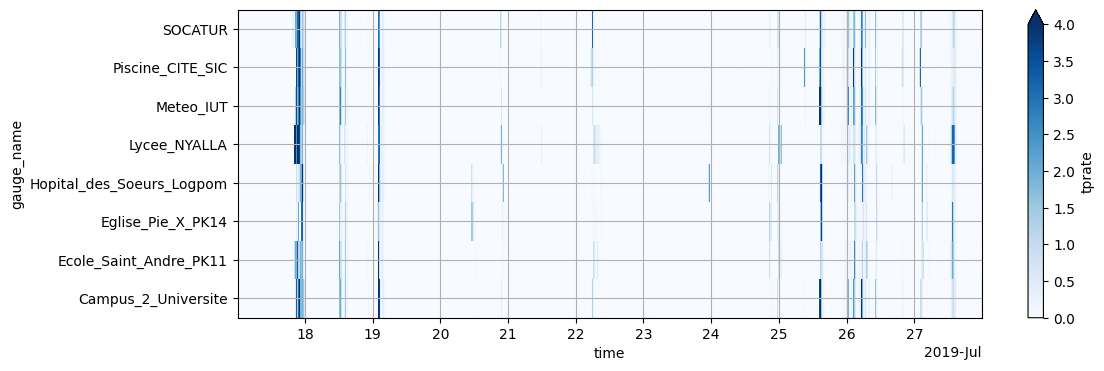

In [ ]:
#| hide
#| eval: false
fig, ax = plt.subplots(figsize=(12, 4))
gauges["tprate"].plot(ax=ax, x="time", cmap=cmap, vmax=4)
ax.set_ylim(ax.get_ylim()[0] - 0.5, ax.get_ylim()[1] + 0.5)
ax.grid()

#| hide
Now that this is good, how can I add the grid to separate each gauge instead of spliting the gauge signal in two?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

The grid lines are currently at the tick positions (center of each gauge). To place them between gauges, you can use minor ticks at the half-integer positions:

```python
ax.set_yticks([i + 0.5 for i in range(len(gauges.gauge_name) - 1)], minor=True)
ax.grid(which='minor', axis='y')
```

This places minor ticks at 0.5, 1.5, 2.5, etc. — right between each gauge row — and then draws the grid on those minor ticks.

In [ ]:
#| hide
#| eval: false
dims = [d for d in gauges.dims if d != "time"]
if len(dims) != 1:
    raise ValueError(f"Expected exactly one non-time dimension, found {len(dims)}: {dims}")
id_dim = dims[0]
id_dim

'gauge_name'

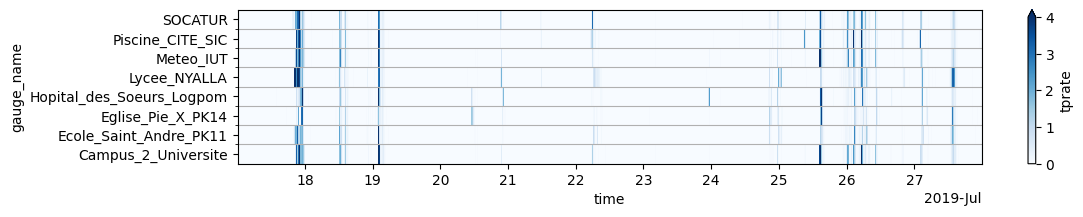

In [ ]:
#| hide
#| eval: false
fig, ax = plt.subplots(figsize=(12, 2))
gauges["tprate"].plot(ax=ax, x="time", cmap=cmap, vmax=4)
ax.set_ylim(ax.get_ylim()[0] - 0.5, ax.get_ylim()[1] + 0.5)
ax.set_yticks([i + 0.5 for i in range(gauges[id_dim].size - 1)], minor=True)
ax.grid(which='minor', axis='y')

In [ ]:
#| export
def romulo_plot_gauges(
        gauges: xr.DataArray, # Gauge data to plot
        fig: plt.Figure = None, 
        ax: plt.Axes = None, 
        figsize: tuple = (12, 2), # Figure size, only used if fig or ax are None
        vmax: float = 4, # Maximum value for colormap
        ) -> tuple[plt.Figure, plt.Axes]:
    """Plot data as a heatmap with grid lines separating each gauge."""
    dims = [d for d in gauges.dims if d != "time"]
    if len(dims) != 1:
        raise ValueError(f"Expected exactly one non-time dimension, found {len(dims)}: {dims}")
    id_dim = dims[0]

    cmap = plt.cm.Blues.copy()
    cmap.set_under('red')
    
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    gauges.plot(ax=ax, x="time", cmap=cmap, vmin=0, vmax=vmax)
    ax.set_ylim(ax.get_ylim()[0] - 0.5, ax.get_ylim()[1] + 0.5)
    ax.set_yticks([i + 0.5 for i in range(gauges[id_dim].size - 1)], minor=True)
    ax.grid(which='minor', axis='y')
    ax.set_ylabel("Gauge")
    
    return fig, ax


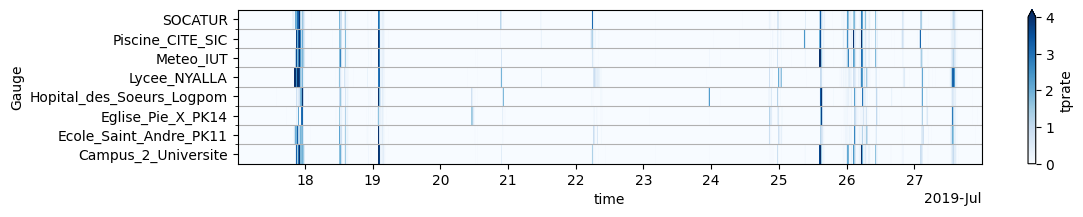

In [ ]:
romulo_plot_gauges(gauges["tprate"]);

## CML and Gauges together

(<Figure size 1600x1000 with 4 Axes>, <Axes: xlabel='time', ylabel='Gauge'>)

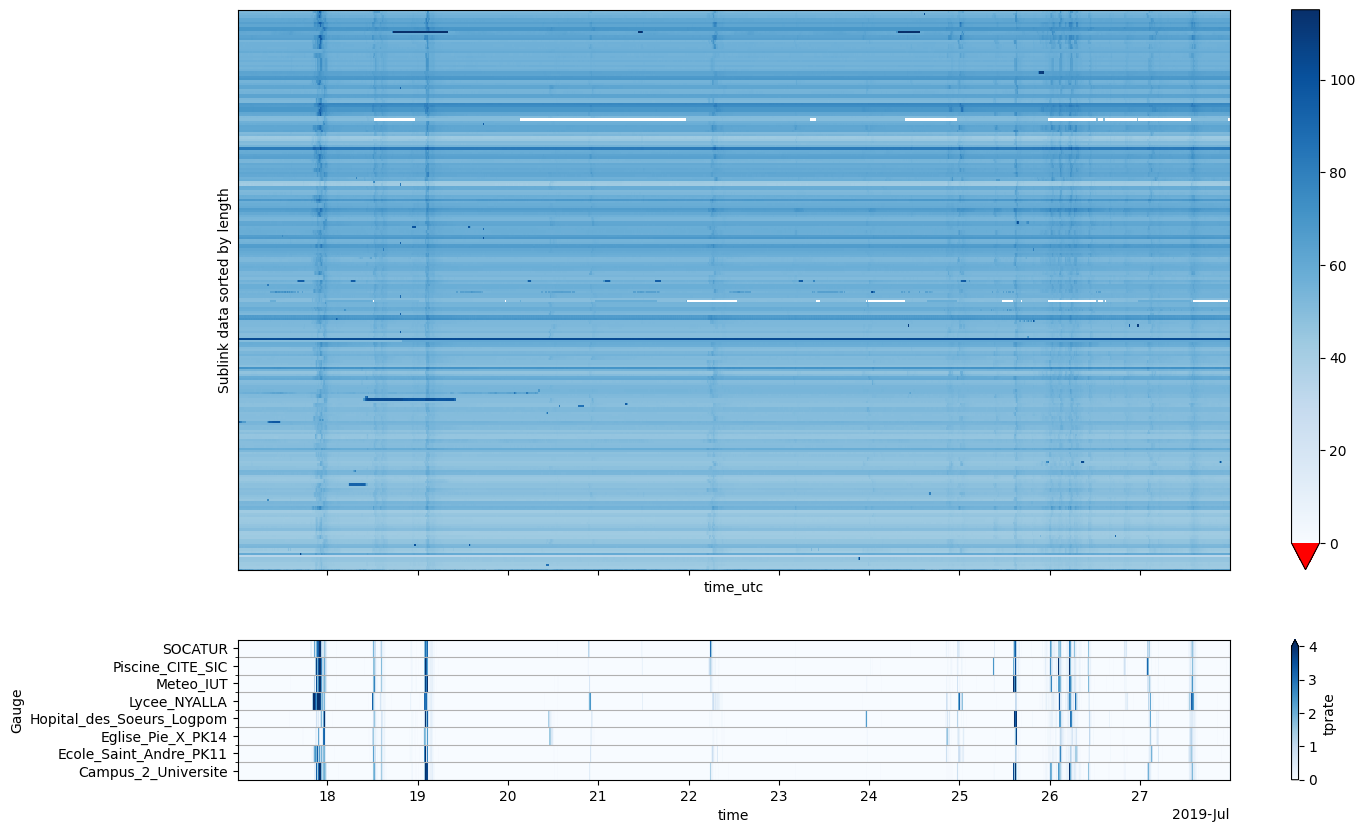

In [ ]:
#| hide
#| eval: false
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(16, 10), gridspec_kw={'height_ratios': [4, 1]})
romulo_plot_cml(att, fig=fig, ax=ax1)
romulo_plot_gauges(gauges["tprate"], fig=fig, ax=ax2)

In [ ]:
#| export
def romulo_plot(
    cml: xr.DataArray, # CML raw or derived data in OpenSense standard
    gauges: xr.DataArray, # Rain gauges data as 2D data array
    title: str | None = None,
    figsize: tuple = (16, 9),
    ratio: int = 4, # Ratio of the CML plot vs Gauges plot
    cml_vmax: float | None = None, # Maximum value for CML colormap
    gauges_vmax: float = 4, # Maximum value for Gauges colormap
    ) -> tuple[plt.Figure, plt.Axes, plt.Axes]:
    fig, (ax_cml, ax_gauges) = plt.subplots(nrows=2, sharex=True, figsize=figsize, gridspec_kw={'height_ratios': [ratio, 1]})
    romulo_plot_cml(cml, title=title, fig=fig, ax=ax_cml, vmax=cml_vmax)
    romulo_plot_gauges(gauges, fig=fig, ax=ax_gauges, vmax=gauges_vmax)
    return fig, ax_cml, ax_gauges

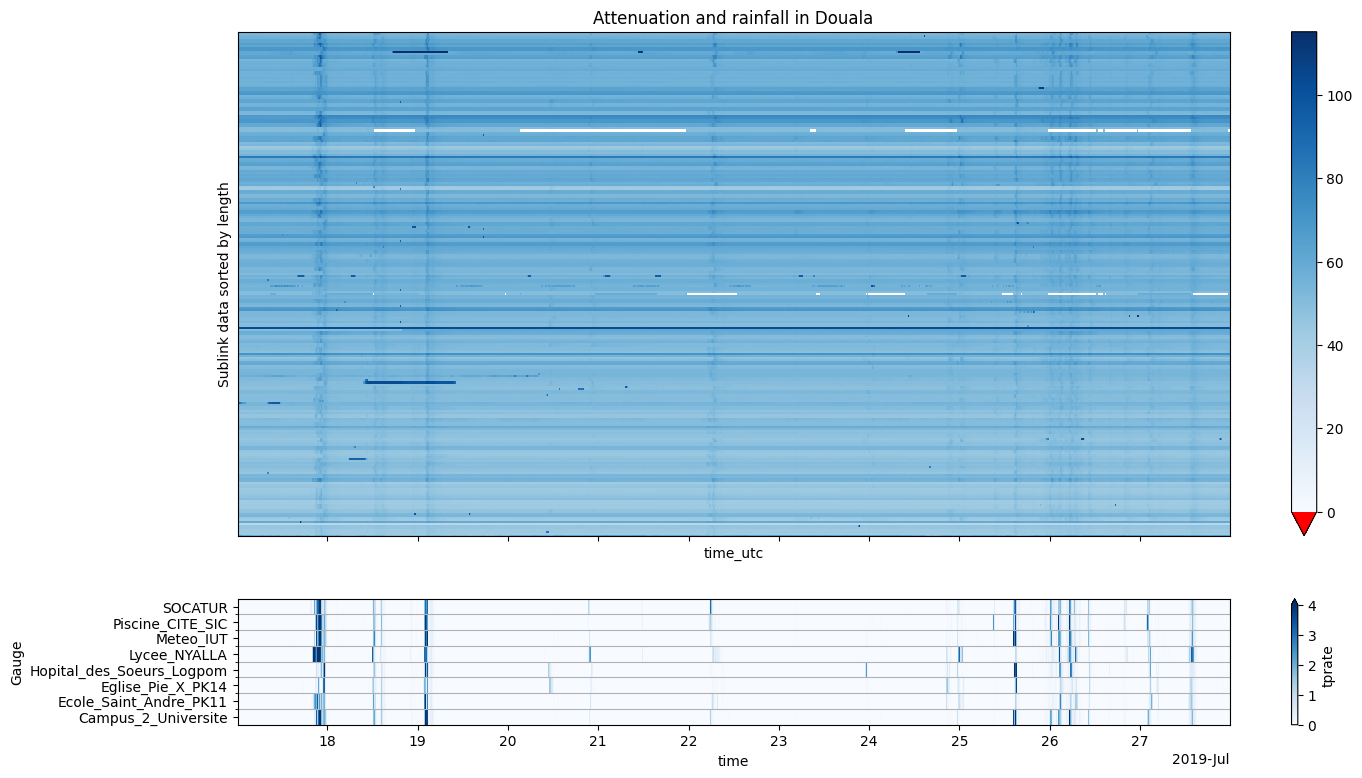

In [ ]:
romulo_plot(att, gauges["tprate"], title="Attenuation and rainfall in Douala");